### Universidad Del Valle de Guatemala
### Departamento de computación
### Modelación y Simulación
### Proyecto
### Diana Lucía Fernández Villatoro - 21747
### Daniel Esteban Morales Urizar - 21785
### Brandon Rolando Sicay Cumes - 21757

In [42]:
import heapq
import random
import time
import matplotlib.pyplot as plt
import numpy as np

random.seed(42)

# Definimos las prioridades de triaje
PRIORIDADES = {
    "I": {"descripcion": "Prioridad absoluta, atención inmediata", "demora_maxima": 0},
    "II": {"descripcion": "Muy urgente, riesgo vital", "demora_maxima": 15},
    "III": {"descripcion": "Urgente pero estable, potencial riesgo vital", "demora_maxima": 60},
    "IV": {"descripcion": "Urgencia menor, sin riesgo vital", "demora_maxima": 120}
}
TIEMPO_MAXIMO = 720

# Contador global de pacientes por prioridad
conteo_prioridades = {"I": 0, "II": 0, "III": 0, "IV": 0}

# Clase para representar a un paciente
class Paciente:
    def __init__(self, nombre, prioridad, tiempo_llegada, tiempo_atencion):
        self.nombre = nombre
        self.prioridad = prioridad
        self.tiempo_llegada = tiempo_llegada  # Se asignará al momento de llegada en la simulación
        self.tiempo_atencion = tiempo_atencion
    def __lt__(self, other):
        return (self.prioridad, self.tiempo_llegada) < (other.prioridad, other.tiempo_llegada)

    def __str__(self):
        return f"{self.nombre} - Prioridad {self.prioridad}: {PRIORIDADES[self.prioridad]['descripcion']}"

# Clase para manejar eventos en la simulación
class Evento:
    def __init__(self, tiempo, tipo, paciente=None, doctor=None):
        self.tiempo = tiempo  # Momento en el que ocurre el evento
        self.tipo = tipo  # "llegada", "inicio_atencion", "fin_atencion"
        self.paciente = paciente
        self.doctor = doctor

    def __lt__(self, other):
        return self.tiempo < other.tiempo

# Generación de pacientes
def generar_pacientes(num_pacientes=10):
    nombres = ["Paciente A", "Paciente B", "Paciente C", "Paciente D", "Paciente E"]
    prioridades = ["I", "II", "III", "IV"]
    pacientes = []
    for _ in range(num_pacientes):
        nombre = random.choice(nombres)
        prioridad = random.choice(prioridades)
        tiempo_llegada = random.randint(1, TIEMPO_MAXIMO)
        tiempo_atencion=random.randint(5, 20)
        pacientes.append(Paciente(nombre, prioridad, tiempo_llegada, tiempo_atencion))
        
        # Actualizar el contador global de pacientes por prioridad
        conteo_prioridades[prioridad] += 1
    
    return pacientes

# Pacientes compartidos por todos los modelos
pacientes_generados = generar_pacientes(220)

# Mostrar el conteo de pacientes por prioridad
print("Conteo de pacientes por prioridad:")
for prioridad, cantidad in conteo_prioridades.items():
    print(f"Prioridad {prioridad}: {cantidad} pacientes")

Conteo de pacientes por prioridad:
Prioridad I: 55 pacientes
Prioridad II: 52 pacientes
Prioridad III: 54 pacientes
Prioridad IV: 59 pacientes


Simulación de un triaje médico y atención médica dependiendo de las prioridades de los pacientes sin posibilidad de interrupción a la atención de un paciente. UN MÉDICO

In [50]:
class CentroSalud:
    def __init__(self):
        self.cola_pacientes = []
        self.eventos = []
        self.tiempo_actual = 0
        self.doctor_ocupado = False
        self.total_pacientes_atendidos= 0
        self.pacientes_atendidos_por_prioridad = {"I": 0, "II": 0, "III": 0, "IV": 0}
        self.pacientes_pendientes = sum(conteo_prioridades.values())  # Inicializar pacientes pendientes
        self.pacientes_pendientes_por_tiempo = []
        self.pacientes_en_espera_tiempo = [] 
        self.tiempos_espera = []

    def agendar_evento(self, evento):
        heapq.heappush(self.eventos, evento)

    def llegada_paciente(self, paciente):
        paciente.tiempo_llegada = self.tiempo_actual  # Asignamos el tiempo de llegada
        print(f"Tiempo {self.tiempo_actual}: Llega {paciente}")
        heapq.heappush(self.cola_pacientes, paciente)
        self.pacientes_en_espera_tiempo.append((self.tiempo_actual, len(self.cola_pacientes)))
        
        if not self.doctor_ocupado:
            self.iniciar_atencion()

    def iniciar_atencion(self):
        if self.cola_pacientes:
            paciente = heapq.heappop(self.cola_pacientes)
            self.doctor_ocupado = True
            fin_atencion = self.tiempo_actual + paciente.tiempo_atencion

            # Calcular y registrar el tiempo de espera del paciente
            tiempo_espera = self.tiempo_actual - paciente.tiempo_llegada
            self.tiempos_espera.append(tiempo_espera)
            
            self.total_pacientes_atendidos += 1
            self.pacientes_atendidos_por_prioridad[paciente.prioridad] += 1
            print(f"Tiempo {self.tiempo_actual}: Inicia atención para {paciente}, tiempo estimado {paciente.tiempo_atencion} minutos")
            self.agendar_evento(Evento(fin_atencion, "fin_atencion", paciente))

    def fin_atencion(self, paciente):
        print(f"Tiempo {self.tiempo_actual}: Finaliza atención para {paciente}")
        self.doctor_ocupado = False
        self.pacientes_pendientes -= 1  # Disminuir el conteo de pacientes pendientes
        self.pacientes_pendientes_por_tiempo.append((self.tiempo_actual, self.pacientes_pendientes))
        self.pacientes_en_espera_tiempo.append((self.tiempo_actual, len(self.cola_pacientes)))
        self.iniciar_atencion()

    def procesar_eventos(self, tiempo_maximo):
        while self.eventos and self.tiempo_actual <= tiempo_maximo:
            evento = heapq.heappop(self.eventos)
            self.tiempo_actual = evento.tiempo
            if evento.tipo == "llegada":
                self.llegada_paciente(evento.paciente)
            elif evento.tipo == "fin_atencion":
                self.fin_atencion(evento.paciente)

    def simular(self, tiempo_maximo):
        # Agendamos las llegadas de pacientes
        for paciente in pacientes_generados:
            self.agendar_evento(Evento(paciente.tiempo_llegada, "llegada", paciente))
        self.procesar_eventos(tiempo_maximo)


centro_salud = CentroSalud()
print("\n--- Simulación Primer Modelo ---\n")
centro_salud.simular(TIEMPO_MAXIMO)
print(centro_salud.total_pacientes_atendidos)


--- Simulación Primer Modelo ---

Tiempo 8: Llega Paciente E - Prioridad II: Muy urgente, riesgo vital
Tiempo 8: Inicia atención para Paciente E - Prioridad II: Muy urgente, riesgo vital, tiempo estimado 7 minutos
Tiempo 15: Finaliza atención para Paciente E - Prioridad II: Muy urgente, riesgo vital
Tiempo 25: Llega Paciente B - Prioridad II: Muy urgente, riesgo vital
Tiempo 25: Inicia atención para Paciente B - Prioridad II: Muy urgente, riesgo vital, tiempo estimado 11 minutos
Tiempo 26: Llega Paciente B - Prioridad IV: Urgencia menor, sin riesgo vital
Tiempo 29: Llega Paciente E - Prioridad III: Urgente pero estable, potencial riesgo vital
Tiempo 33: Llega Paciente E - Prioridad IV: Urgencia menor, sin riesgo vital
Tiempo 36: Finaliza atención para Paciente B - Prioridad II: Muy urgente, riesgo vital
Tiempo 36: Inicia atención para Paciente E - Prioridad III: Urgente pero estable, potencial riesgo vital, tiempo estimado 8 minutos
Tiempo 43: Llega Paciente D - Prioridad II: Muy urge

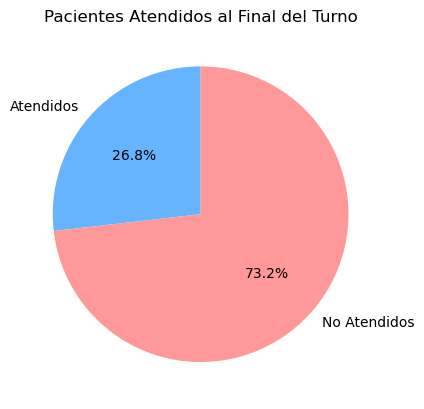

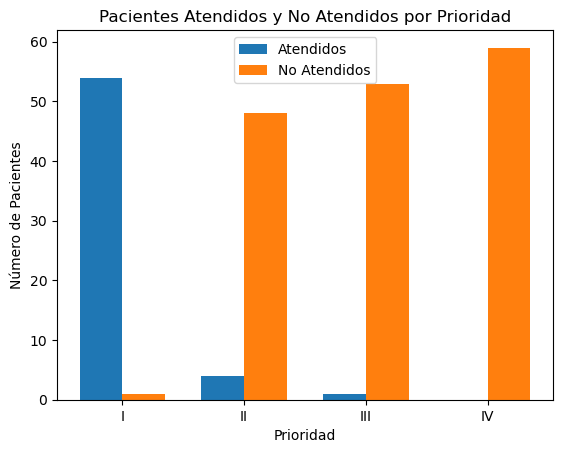

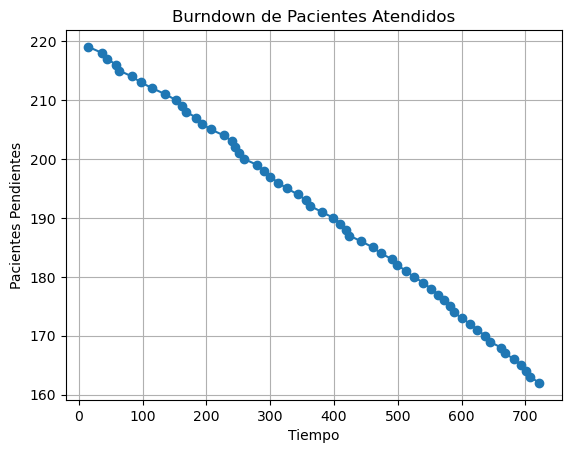

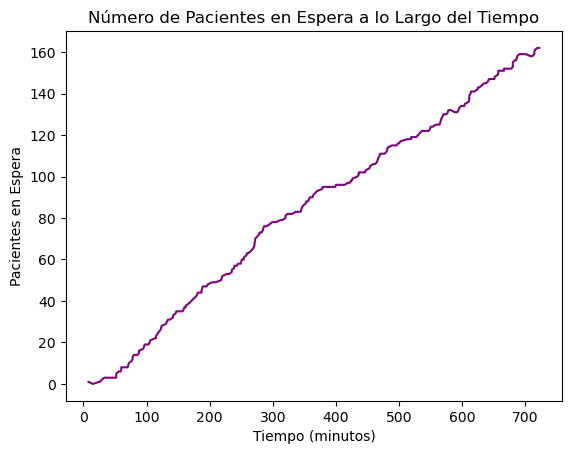

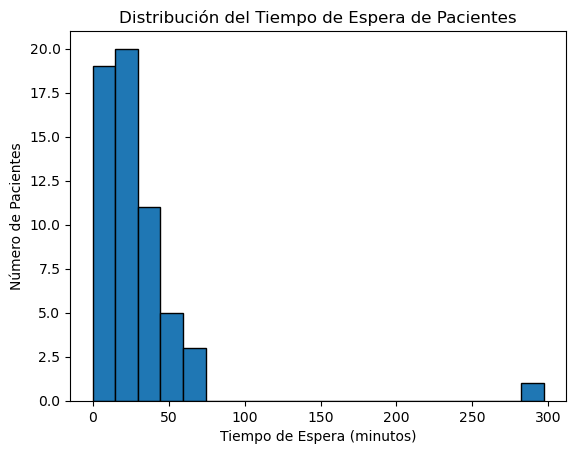

In [45]:
# ------------------- Distribución total de pacientes atendidos (final del turno) -------------------
total_pacientes = centro_salud.total_pacientes_atendidos
no_atendidos = len(pacientes_generados) - total_pacientes

plt.figure()
plt.pie([total_pacientes, no_atendidos],
        labels=['Atendidos', 'No Atendidos'],
        autopct=lambda p: f'{p:.1f}%',
        startangle=90, colors=['#66b3ff', '#ff9999'])
plt.title("Pacientes Atendidos al Final del Turno")
plt.show()

# ------------------- Distribución total de pacientes atendidos por prioridad -------------------
# Calcular pacientes no atendidos
pacientes_no_atendidos_por_prioridad = {
    prioridad: conteo_prioridades[prioridad] - centro_salud.pacientes_atendidos_por_prioridad[prioridad]
    for prioridad in conteo_prioridades
}

# Preparar datos para el gráfico
prioridades = ["I", "II", "III", "IV"]
atendidos = [centro_salud.pacientes_atendidos_por_prioridad[prioridad] for prioridad in prioridades]
no_atendidos = [pacientes_no_atendidos_por_prioridad[prioridad] for prioridad in prioridades]

# Crear gráfico de barras agrupadas
bar_width = 0.35
index = range(len(prioridades))

fig, ax = plt.subplots()
bar1 = ax.bar(index, atendidos, bar_width, label='Atendidos')
bar2 = ax.bar([i + bar_width for i in index], no_atendidos, bar_width, label='No Atendidos')

# Configuración del gráfico
ax.set_xlabel('Prioridad')
ax.set_ylabel('Número de Pacientes')
ax.set_title('Pacientes Atendidos y No Atendidos por Prioridad')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(prioridades)
ax.legend()
plt.show()

# ------------------- Gráfico burndown de pacientes pendientes -------------------
# Preparar datos para el gráfico burndown
tiempos = [t for t, _ in centro_salud.pacientes_pendientes_por_tiempo]
pacientes_pendientes = [p for _, p in centro_salud.pacientes_pendientes_por_tiempo]

# Crear el gráfico burndown
plt.figure()
plt.plot(tiempos, pacientes_pendientes, marker='o')
plt.xlabel("Tiempo")
plt.ylabel("Pacientes Pendientes")
plt.title("Burndown de Pacientes Atendidos")
plt.grid(True)
plt.show()

# ------------------- Número de pacientes en espera a lo largo del tiempo -------------------
# Extraer datos para el gráfico de pacientes en espera
tiempos, pacientes_en_espera = zip(*centro_salud.pacientes_en_espera_tiempo)
plt.figure()
plt.plot(tiempos, pacientes_en_espera, color='purple')
plt.title("Número de Pacientes en Espera a lo Largo del Tiempo")
plt.xlabel("Tiempo (minutos)")
plt.ylabel("Pacientes en Espera")
plt.show()

# ------------------- Distribución del tiempo de espera -------------------
# Crear la gráfica de distribución del tiempo de espera
plt.figure()
plt.hist(centro_salud.tiempos_espera, bins=20, edgecolor='black')
plt.xlabel("Tiempo de Espera (minutos)")
plt.ylabel("Número de Pacientes")
plt.title("Distribución del Tiempo de Espera de Pacientes")
plt.show()


Simulación de un triaje médico y atención médica dependiendo de las prioridades de los pacientes con posibilidad de interrupción a la atención de un paciente. UN MÉDICO

In [66]:
class CentroSaludInterrumpible(CentroSalud):
    def __init__(self):
        super().__init__()
        self.paciente_actual = None
        self.pacientes_atendidos = 0  
        self.pacientes_atendidos_por_prioridad_interrumpible = {"I": 0, "II": 0, "III": 0, "IV": 0}
        self.pacientes_pendientes_interrumpible = sum(conteo_prioridades.values())  # Inicializar pacientes pendientes
        self.pacientes_pendientes_por_tiempo_interrumpible = []
        self.pacientes_en_espera_tiempo_interrumpible = [] 
        self.tiempos_espera_interrumpible = []

    def llegada_paciente(self, paciente):
        paciente.tiempo_llegada = self.tiempo_actual  # Asignamos el tiempo de llegada
        paciente.interrumpido = False  # Inicialmente, el paciente no ha sido interrumpido
        print(f"Tiempo {self.tiempo_actual}: Llega {paciente}")
        self.pacientes_en_espera_tiempo_interrumpible.append((self.tiempo_actual, len(self.cola_pacientes)))
        
        if not self.doctor_ocupado:
            self.iniciar_atencion(paciente)
        else:
            # Verificamos si el nuevo paciente tiene mayor prioridad
            if paciente.prioridad < self.paciente_actual.prioridad:
                print(f"Tiempo {self.tiempo_actual}: {paciente} interrumpe la atención de {self.paciente_actual}")
                # Marcar al paciente actual como interrumpido
                self.paciente_actual.interrumpido = True
                # Regresamos al paciente actual a la cola
                heapq.heappush(self.cola_pacientes, self.paciente_actual)
                # Atendemos al nuevo paciente
                self.iniciar_atencion(paciente)
            else:
                # Agregamos el nuevo paciente a la cola
                heapq.heappush(self.cola_pacientes, paciente)

    def iniciar_atencion(self, paciente=None):
        if not paciente and self.cola_pacientes:
            paciente = heapq.heappop(self.cola_pacientes)
        if paciente:
            self.paciente_actual = paciente
            self.doctor_ocupado = True
            fin_atencion = self.tiempo_actual + paciente.tiempo_atencion
            tiempo_espera = self.tiempo_actual - paciente.tiempo_llegada  # Calcular el tiempo de espera
            self.tiempos_espera_interrumpible.append(tiempo_espera)
            print(f"Tiempo {self.tiempo_actual}: Inicia atención para {paciente}, tiempo estimado {paciente.tiempo_atencion} minutos")

            self.agendar_evento(Evento(fin_atencion, "fin_atencion", paciente))

    def fin_atencion(self, paciente):
        print(f"Tiempo {self.tiempo_actual}: Finaliza atención para {paciente}")
        self.doctor_ocupado = False
        self.paciente_actual = None
        # Solo incrementar el contador si el paciente no fue interrumpido
        if not paciente.interrumpido:
            self.pacientes_atendidos += 1
            self.pacientes_atendidos_por_prioridad_interrumpible[paciente.prioridad] += 1
            self.pacientes_pendientes_interrumpible -= 1  # Disminuir el conteo de pacientes pendientes
            self.pacientes_pendientes_por_tiempo_interrumpible.append((self.tiempo_actual, self.pacientes_pendientes_interrumpible))
            self.pacientes_en_espera_tiempo_interrumpible.append((self.tiempo_actual, len(self.cola_pacientes)))
        
        self.iniciar_atencion()

# Ejecutar la simulación del segundo modelo
centro_salud_interrumpible = CentroSaludInterrumpible()
print("\n--- Simulación Segundo Modelo ---\n")
centro_salud_interrumpible.simular(TIEMPO_MAXIMO)

# Imprimir el contador al final de la simulación
print(f"\nTotal de pacientes atendidos: {centro_salud_interrumpible.pacientes_atendidos}")



--- Simulación Segundo Modelo ---

Tiempo 8: Llega Paciente E - Prioridad II: Muy urgente, riesgo vital
Tiempo 8: Inicia atención para Paciente E - Prioridad II: Muy urgente, riesgo vital, tiempo estimado 7 minutos
Tiempo 15: Finaliza atención para Paciente E - Prioridad II: Muy urgente, riesgo vital
Tiempo 25: Llega Paciente B - Prioridad II: Muy urgente, riesgo vital
Tiempo 25: Inicia atención para Paciente B - Prioridad II: Muy urgente, riesgo vital, tiempo estimado 11 minutos
Tiempo 26: Llega Paciente B - Prioridad IV: Urgencia menor, sin riesgo vital
Tiempo 29: Llega Paciente E - Prioridad III: Urgente pero estable, potencial riesgo vital
Tiempo 33: Llega Paciente E - Prioridad IV: Urgencia menor, sin riesgo vital
Tiempo 36: Finaliza atención para Paciente B - Prioridad II: Muy urgente, riesgo vital
Tiempo 36: Inicia atención para Paciente E - Prioridad III: Urgente pero estable, potencial riesgo vital, tiempo estimado 8 minutos
Tiempo 43: Llega Paciente D - Prioridad II: Muy urg

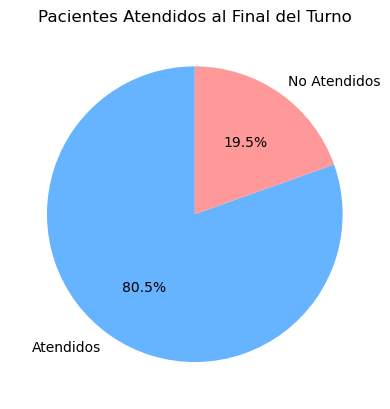

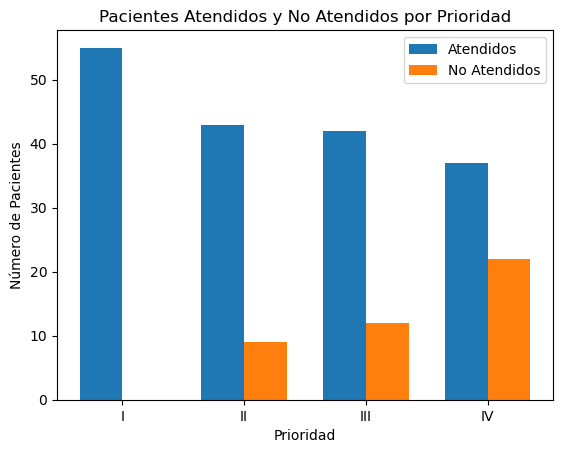

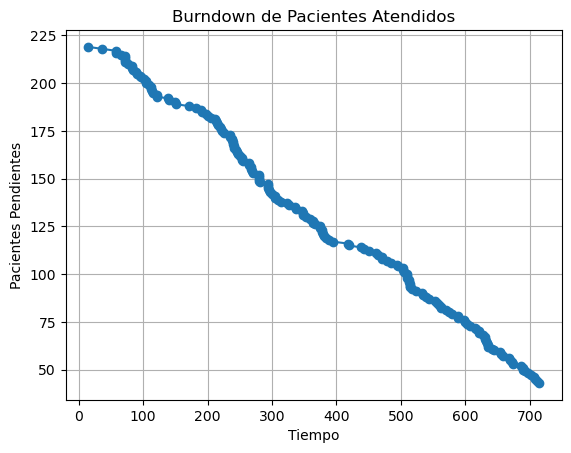

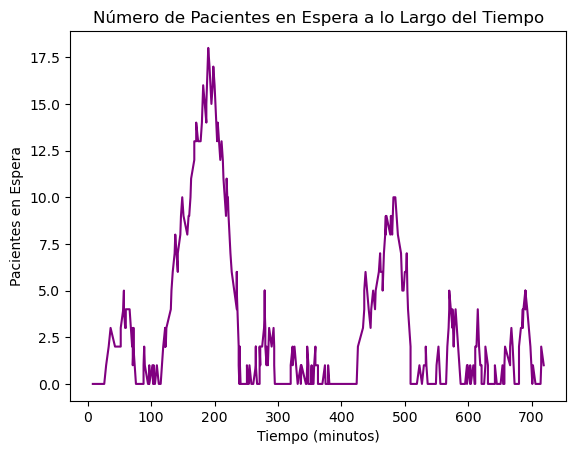

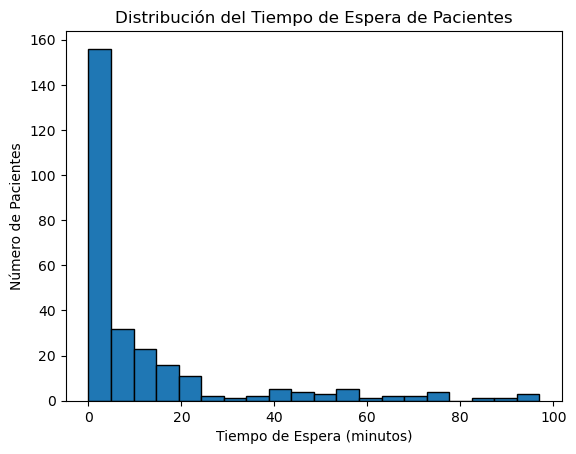

In [72]:
# ------------------- Distribución total de pacientes atendidos (final del turno) -------------------
total_pacientes = centro_salud_interrumpible.pacientes_atendidos
no_atendidos = len(pacientes_generados) - total_pacientes

plt.figure()
plt.pie([total_pacientes, no_atendidos],
        labels=['Atendidos', 'No Atendidos'],
        autopct=lambda p: f'{p:.1f}%',
        startangle=90, colors=['#66b3ff', '#ff9999'])
plt.title("Pacientes Atendidos al Final del Turno")
plt.show()

# ------------------- Distribución total de pacientes atendidos por prioridad -------------------
# Calcular pacientes no atendidos
pacientes_no_atendidos_por_prioridad = {
    prioridad: conteo_prioridades[prioridad] - centro_salud_interrumpible.pacientes_atendidos_por_prioridad_interrumpible[prioridad]
    for prioridad in conteo_prioridades
}

# Preparar datos para el gráfico
prioridades = ["I", "II", "III", "IV"]
atendidos = [centro_salud_interrumpible.pacientes_atendidos_por_prioridad_interrumpible[prioridad] for prioridad in prioridades]
no_atendidos = [pacientes_no_atendidos_por_prioridad[prioridad] for prioridad in prioridades]

# Crear gráfico de barras agrupadas
bar_width = 0.35
index = range(len(prioridades))

fig, ax = plt.subplots()
bar1 = ax.bar(index, atendidos, bar_width, label='Atendidos')
bar2 = ax.bar([i + bar_width for i in index], no_atendidos, bar_width, label='No Atendidos')

# Configuración del gráfico
ax.set_xlabel('Prioridad')
ax.set_ylabel('Número de Pacientes')
ax.set_title('Pacientes Atendidos y No Atendidos por Prioridad')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(prioridades)
ax.legend()
plt.show()

# ------------------- Gráfico burndown de pacientes pendientes -------------------
# Preparar datos para el gráfico burndown
tiempos = [t for t, _ in centro_salud_interrumpible.pacientes_pendientes_por_tiempo_interrumpible]
pacientes_pendientes = [p for _, p in centro_salud_interrumpible.pacientes_pendientes_por_tiempo_interrumpible]

# Crear el gráfico burndown
plt.figure()
plt.plot(tiempos, pacientes_pendientes, marker='o')
plt.xlabel("Tiempo")
plt.ylabel("Pacientes Pendientes")
plt.title("Burndown de Pacientes Atendidos")
plt.grid(True)
plt.show()

# ------------------- Número de pacientes en espera a lo largo del tiempo -------------------
# Extraer datos para el gráfico de pacientes en espera
tiempos, pacientes_en_espera = zip(*centro_salud_interrumpible.pacientes_en_espera_tiempo_interrumpible)
plt.figure()
plt.plot(tiempos, pacientes_en_espera, color='purple')
plt.title("Número de Pacientes en Espera a lo Largo del Tiempo")
plt.xlabel("Tiempo (minutos)")
plt.ylabel("Pacientes en Espera")
plt.show()

# ------------------- Distribución del tiempo de espera -------------------
# Crear la gráfica de distribución del tiempo de espera
plt.figure()
plt.hist(centro_salud_interrumpible.tiempos_espera_interrumpible, bins=20, edgecolor='black')
plt.xlabel("Tiempo de Espera (minutos)")
plt.ylabel("Número de Pacientes")
plt.title("Distribución del Tiempo de Espera de Pacientes")
plt.show()


Simulación de un centro médico con VARIOS DOCTORES, con posibilidad de que una emergencia interrumpa la atención de un paciente de menor prioridad

In [74]:
import heapq

class Doctor:
    def __init__(self, id_doctor):
        self.id_doctor = id_doctor
        self.ocupado = False
        self.paciente_actual = None
        self.tiempo_fin_atencion = 0

    def __str__(self):
        return f"Doctor {self.id_doctor}"

class CentroSaludMulticanal:
    def __init__(self, num_doctores, politica_interrupcion=True):
        self.cola_pacientes = []
        self.eventos = []
        self.tiempo_actual = 0
        self.politica_interrupcion = politica_interrupcion
        self.total_pacientes_atendidos = 0
        self.pacientes_pendientes = sum(conteo_prioridades.values())
        self.pacientes_pendientes_por_tiempo = []
        self.doctores = [Doctor(i) for i in range(num_doctores)]
        for doctor in self.doctores:
            doctores_atenciones[doctor.id_doctor] = 0

    def agendar_evento(self, evento):
        heapq.heappush(self.eventos, evento)

    def llegada_paciente(self, paciente):
        paciente.tiempo_llegada = self.tiempo_actual
        paciente.interrumpido = False  # Inicializar la bandera de interrupción
        print(f"Tiempo {self.tiempo_actual}: Llega {paciente}")
        
        # Buscar un doctor disponible
        doctor_libre = next((doctor for doctor in self.doctores if not doctor.ocupado), None)

        if doctor_libre:
            # Si hay un doctor libre, iniciamos atención inmediata
            self.iniciar_atencion(paciente, doctor_libre)
        else:
            # Si todos los doctores están ocupados, verificar interrupción
            if self.politica_interrupcion:
                doctor_a_interrumpir = next(
                    (doctor for doctor in self.doctores if paciente.prioridad < doctor.paciente_actual.prioridad),
                    None
                )
                if doctor_a_interrumpir:
                    # Marcar al paciente actual como interrumpido y ponerlo de vuelta en la cola
                    doctor_a_interrumpir.paciente_actual.interrumpido = True
                    print(f"Tiempo {self.tiempo_actual}: {paciente} interrumpe la atención de {doctor_a_interrumpir.paciente_actual}")
                    heapq.heappush(self.cola_pacientes, doctor_a_interrumpir.paciente_actual)
                    # Iniciar atención al nuevo paciente
                    self.iniciar_atencion(paciente, doctor_a_interrumpir)
                else:
                    # Si no puede interrumpir, el paciente espera en la cola
                    heapq.heappush(self.cola_pacientes, paciente)
            else:
                heapq.heappush(self.cola_pacientes, paciente)

        # Registrar el número total de pacientes en espera (en cola y en atención) en este momento
        pacientes_en_espera_tiempo.append((self.tiempo_actual, len(self.cola_pacientes) + sum(1 for doctor in self.doctores if doctor.ocupado)))

    def iniciar_atencion(self, paciente, doctor):
        doctor.ocupado = True
        doctor.paciente_actual = paciente
        tiempo_atencion = paciente.tiempo_atencion  # Usamos el tiempo de atención predefinido del paciente
        doctor.tiempo_fin_atencion = self.tiempo_actual + tiempo_atencion

        # Calcular y guardar el tiempo de espera del paciente
        tiempo_espera = self.tiempo_actual - paciente.tiempo_llegada
        tiempos_espera.append(tiempo_espera)
        
        # Guardar el tiempo de atención por prioridad
        tiempos_atencion_por_prioridad[paciente.prioridad].append(tiempo_atencion)

        print(f"Tiempo {self.tiempo_actual}: {doctor} inicia atención para {paciente}, tiempo estimado {tiempo_atencion} minutos")
        self.agendar_evento(Evento(doctor.tiempo_fin_atencion, "fin_atencion", paciente, doctor))

    def fin_atencion(self, doctor):
        paciente = doctor.paciente_actual
        print(f"Tiempo {self.tiempo_actual}: {doctor} finaliza atención para {paciente}")
        doctor.ocupado = False
        doctor.paciente_actual = None

        # Solo contar el paciente si fue atendido completamente y no fue interrumpido
        if paciente and not paciente.interrumpido:
            self.total_pacientes_atendidos += 1
            doctores_atenciones[doctor.id_doctor] += 1

        self.pacientes_pendientes -= 1
        self.pacientes_pendientes_por_tiempo.append((self.tiempo_actual, self.pacientes_pendientes))

        # Si hay más pacientes en la cola, atender al siguiente
        if self.cola_pacientes:
            siguiente_paciente = heapq.heappop(self.cola_pacientes)
            self.iniciar_atencion(siguiente_paciente, doctor)

        # Registrar el número total de pacientes en espera (en cola y en atención) en este momento
        pacientes_en_espera_tiempo.append((self.tiempo_actual, len(self.cola_pacientes) + sum(1 for doctor in self.doctores if doctor.ocupado)))

    def procesar_eventos(self, tiempo_maximo):
        while self.eventos and self.tiempo_actual <= tiempo_maximo:
            evento = heapq.heappop(self.eventos)
            self.tiempo_actual = evento.tiempo
            if evento.tipo == "llegada":
                self.llegada_paciente(evento.paciente)
            elif evento.tipo == "fin_atencion":
                self.fin_atencion(evento.doctor)

    def simular(self, tiempo_maximo):
        # Agendar las llegadas de pacientes
        for paciente in pacientes_generados:
            self.agendar_evento(Evento(paciente.tiempo_llegada, "llegada", paciente))
        self.procesar_eventos(tiempo_maximo)

# Ejecutar la simulación del modelo multicanal con interrupciones
num_doctores = 3
centro_salud_multicanal = CentroSaludMulticanal(num_doctores)
print("\n--- Simulación Tercer Modelo ---\n")
centro_salud_multicanal.simular(TIEMPO_MAXIMO)

print(centro_salud_multicanal.total_pacientes_atendidos)



--- Simulación Tercer Modelo ---

Tiempo 8: Llega Paciente E - Prioridad II: Muy urgente, riesgo vital
Tiempo 8: Doctor 0 inicia atención para Paciente E - Prioridad II: Muy urgente, riesgo vital, tiempo estimado 7 minutos
Tiempo 15: Doctor 0 finaliza atención para Paciente E - Prioridad II: Muy urgente, riesgo vital
Tiempo 25: Llega Paciente B - Prioridad II: Muy urgente, riesgo vital
Tiempo 25: Doctor 0 inicia atención para Paciente B - Prioridad II: Muy urgente, riesgo vital, tiempo estimado 11 minutos
Tiempo 26: Llega Paciente B - Prioridad IV: Urgencia menor, sin riesgo vital
Tiempo 26: Doctor 1 inicia atención para Paciente B - Prioridad IV: Urgencia menor, sin riesgo vital, tiempo estimado 10 minutos
Tiempo 29: Llega Paciente E - Prioridad III: Urgente pero estable, potencial riesgo vital
Tiempo 29: Doctor 2 inicia atención para Paciente E - Prioridad III: Urgente pero estable, potencial riesgo vital, tiempo estimado 8 minutos
Tiempo 33: Llega Paciente E - Prioridad IV: Urgenci

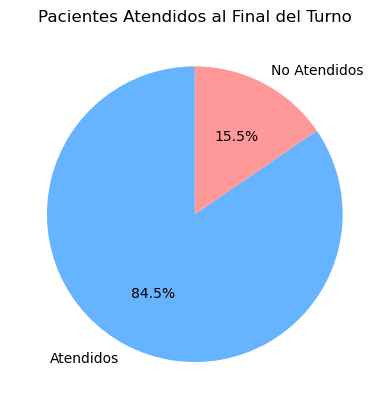

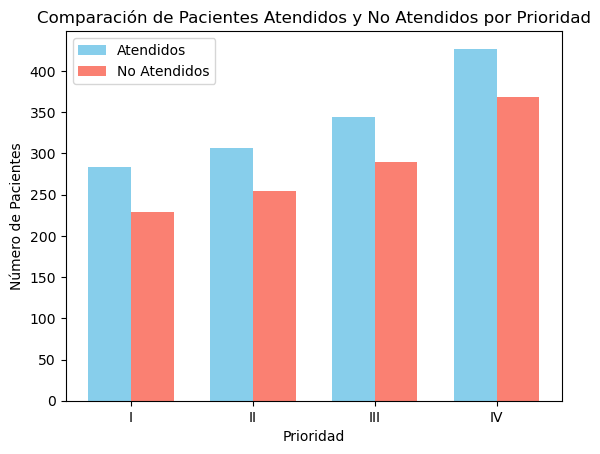

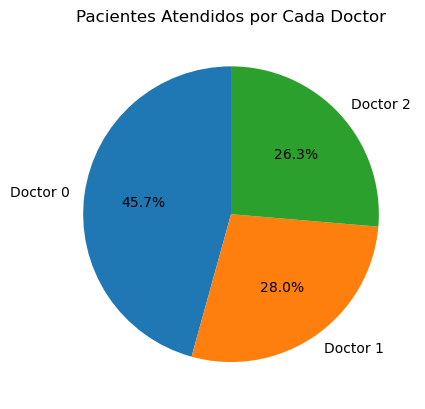

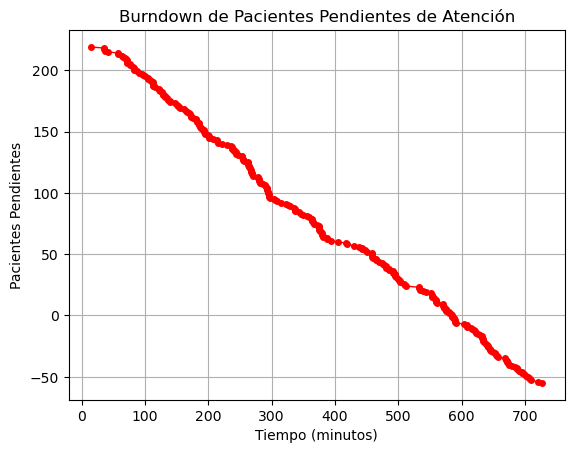

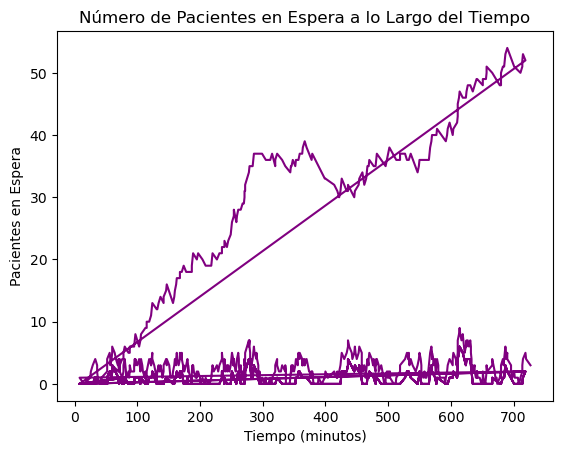

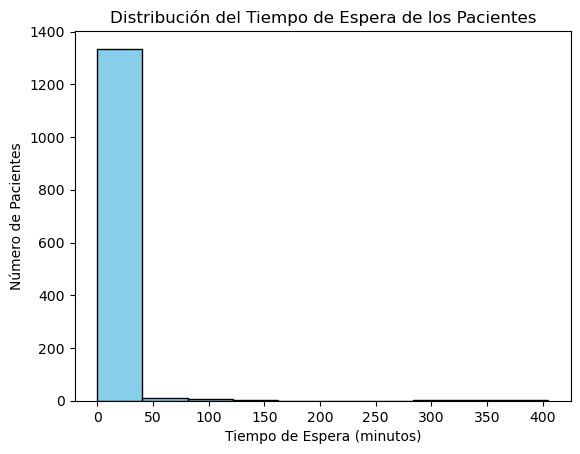

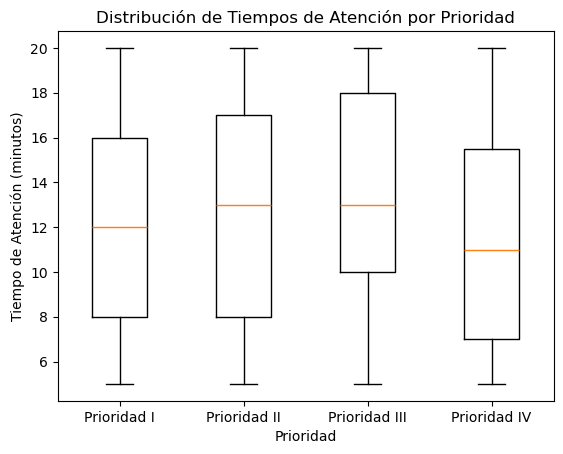

In [75]:
# ------------------- Distribución total de pacientes atendidos (final del turno) -------------------
total_pacientes = centro_salud_multicanal.total_pacientes_atendidos
no_atendidos = len(pacientes_generados) - total_pacientes

plt.figure()
plt.pie([total_pacientes, no_atendidos],
        labels=['Atendidos', 'No Atendidos'],
        autopct=lambda p: f'{p:.1f}%',
        startangle=90, colors=['#66b3ff','#ff9999'])
plt.title("Pacientes Atendidos al Final del Turno")
plt.show()

# ------------------- Pacientes atendidos vs no atendidos -------------------
# Calcular el número de pacientes atendidos y no atendidos por prioridad
prioridades = list(conteo_prioridades.keys())
pacientes_atendidos = [len(tiempos_atencion_por_prioridad[prioridad]) for prioridad in prioridades]
pacientes_no_atendidos = [-(conteo_prioridades[prioridad] - len(tiempos_atencion_por_prioridad[prioridad])) for prioridad in prioridades]

x = np.arange(len(prioridades))  # Posiciones en el eje x
width = 0.35  # Ancho de las barras

fig, ax = plt.subplots()
barras_atendidos = ax.bar(x - width/2, pacientes_atendidos, width, label='Atendidos', color='skyblue')
barras_no_atendidos = ax.bar(x + width/2, pacientes_no_atendidos, width, label='No Atendidos', color='salmon')

# Añadir etiquetas y título
ax.set_xlabel("Prioridad")
ax.set_ylabel("Número de Pacientes")
ax.set_title("Comparación de Pacientes Atendidos y No Atendidos por Prioridad")
ax.set_xticks(x)
ax.set_xticklabels(prioridades)
ax.legend()
plt.show()

# ------------------- Cantidad de pacientes atendidos por cada doctor -------------------
doctor_ids, atenciones = zip(*doctores_atenciones.items())
total_pacientes = sum(atenciones)

plt.figure()
plt.pie(
    atenciones,
    labels=[f'Doctor {id}' for id in doctor_ids],
    autopct=lambda p: f'{p:.1f}%',
    startangle=90
)
plt.title("Pacientes Atendidos por Cada Doctor")
plt.show()

# ------------------- Burndown de pacientes atendidos -------------------
# Extraer los tiempos y los pacientes pendientes de la lista registrada en la simulación
tiempos, pacientes_pendientes = zip(*centro_salud_multicanal.pacientes_pendientes_por_tiempo)

plt.figure()
plt.plot(tiempos, pacientes_pendientes, color='red', marker='o', linestyle='-', linewidth=1, markersize=4)
plt.title("Burndown de Pacientes Pendientes de Atención")
plt.xlabel("Tiempo (minutos)")
plt.ylabel("Pacientes Pendientes")
plt.grid(True)
plt.show()

# ------------------- Número de pacientes en espera a lo largo del tiempo -------------------
tiempos, pacientes_en_espera = zip(*pacientes_en_espera_tiempo)
plt.figure()
plt.plot(tiempos, pacientes_en_espera, color='purple')
plt.title("Número de Pacientes en Espera a lo Largo del Tiempo")
plt.xlabel("Tiempo (minutos)")
plt.ylabel("Pacientes en Espera")
plt.show()

# ------------------- Tiempo de espera promedio de los pacientes -------------------
plt.figure()
plt.hist(tiempos_espera, bins=10, color='skyblue', edgecolor='black')
plt.title("Distribución del Tiempo de Espera de los Pacientes")
plt.xlabel("Tiempo de Espera (minutos)")
plt.ylabel("Número de Pacientes")
plt.show()

# ------------------- Distribución de tiempos de atención por prioridad -------------------
# Convertir los tiempos de atención por prioridad en un formato adecuado para el boxplot
data = [tiempos_atencion_por_prioridad["I"], tiempos_atencion_por_prioridad["II"], 
        tiempos_atencion_por_prioridad["III"], tiempos_atencion_por_prioridad["IV"]]

plt.figure()
plt.boxplot(data, labels=["Prioridad I", "Prioridad II", "Prioridad III", "Prioridad IV"])
plt.title("Distribución de Tiempos de Atención por Prioridad")
plt.xlabel("Prioridad")
plt.ylabel("Tiempo de Atención (minutos)")
plt.show()